##**Imports**##

In [50]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [51]:
import numpy as np
import h5py as h5
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import pdb

##**ITrainable Interface**##

In [52]:
class ITrainable():
    """
    Interface for all trainable objects in the neural network.
    This interface defines the methods that all trainable objects must implement.
    It is an interface and so no function is implemented.
    """
    def forward_propagation(self, X):
      raise NotImplementedError("Not implemented - ITrainable is an interface")
    def backward_propagation(self, dY_hat):
      raise NotImplementedError("Not implemented - ITrainable is an interface")
    def update_parameters(self):
      raise NotImplementedError("Not implemented - ITrainable is an interface")
    def save_parameters(self, dir_path):
      raise NotImplementedError("Not implemented - ITrainable is an interface")
    def load_parameters():
      raise NotImplementedError("Not implemented - ITrainable is an interface")


##**Network**##

In [53]:
class Network(ITrainable):
  def __init__(self, network=[]):
    # Initialize the network with a list of layers (default is an empty list)
    self.layers = network
    # Set a name for the network
    self.name = "Yaeden's ANN"

  def __str__(self):
    # Define a string representation of the network
    s = f"Network: \n"
    j = 0
    for i in self.layers:
      j += 1
      s += f"{j}. {i}\n"
    return s

  def add(self, iTrainable):
    # Add a new layer to the network
    self.layers.append(iTrainable)

  def forward_propagation(self, X):
    # Perform forward propagation through all layers
    p = X
    for i in self.layers:
      p = i.forward_propagation(p)
    return p

  def backward_propagation(self, dY_hat):
    # Perform backward propagation through all layers in reverse order
    p = dY_hat
    for i in reversed(self.layers):
      p = i.backward_propagation(p)
    return p

  def update_parameters(self, optimization):
    # Update parameters of all layers using the given optimization method
    for layer in self.layers:
      layer.update_parameters(optimization)

  def save_parameters(self, dir_path):
    # Save parameters of all layers to the specified directory
    path = dir_path + "/" + self.name
    if os.path.exists(path) == False:
      os.mkdir(path)
    for layer in self.layers:
      layer.save_parameters(path)

  def load_parameters(self, dir_path):
    # Load parameters of all layers from the specified directory
    path = dir_path + "/" + self.name
    for layer in self.layers:
      layer.load_parameters(path)

##**Dense Layer**##

In [54]:
class DenseLayer(ITrainable):
  def __init__(self, input_size, layer_size, alpha, name):
    # Initialize parameters
    self.alpha = alpha  # Learning rate
    self.name = name  # Name of the layer
    self.optimization = None  # Optimization method (default: None)
    self.layer_size = layer_size  # Number of units in the layer
    self.input_size = input_size  # Number of input features
    # Initialize weights using He initialization
    self.W = np.random.randn(layer_size, input_size) * np.sqrt(2 / input_size)
    # Initialize biases
    self.b = np.random.randn(layer_size, 1)
    # Adaptive learning rate parameters
    self.adaptive_cont = 1.1
    self.adaptive_switch = 0.5
    self.adaptive_W = np.ones_like(self.W) * alpha
    self.adaptive_b = np.ones_like(self.b) * alpha

  def __str__(self):
    # Return a string representation of the layer
    s = f"Dense Layer:\n"
    s += f"\tlearning_rate (alpha): {self.alpha}\n"
    s += f"\tnum inputs: {self.input_size}\n"
    s += f"\tnum units: {self.layer_size}\n"
    if self.optimization != None:
      s += f"\tOptimization: {self.optimization}\n"
      if self.optimization == "adaptive":
        s += f"\t\tadaptive parameters:\n"
        s += f"\t\t\tcont: {self.adaptive_cont}\n"
        s += f"\t\t\tswitch: {self.adaptive_switch}\n"
    s += "\tParameters shape:\n"
    s += f"\t\tW shape: {self.W.shape}\n"
    s += f"\t\tb shape: {self.b.shape}\n"
    return s

  def forward_propagation(self, prev_A):
    # Compute the linear transformation of inputs
    self.prev_A = prev_A
    Z = np.dot(self.W, self.prev_A) + self.b
    return Z

  def backward_propagation(self, dZ):
    # Compute gradients with respect to weights and inputs
    self.dW = np.dot(dZ, self.prev_A.T)
    self.dZ = np.copy(dZ)
    input_gradient = np.dot(self.W.T, self.dZ)
    return input_gradient

  def update_parameters(self, optimization):
    if optimization == 'adaptive':
      # Update parameters using adaptive learning rate
      self.adaptive_W += self.dW**2
      self.W -= self.alpha / np.sqrt(self.adaptive_W + 1e-8) * self.dW
      self.adaptive_b += self.dZ**2
      self.b -= self.alpha / np.sqrt(self.adaptive_b + 1e-8) * self.dZ
    else:
      # Standard gradient descent update
      self.W -= self.alpha * self.dW
      self.b -= self.alpha * self.dZ

  def save_parameters(self, file_path):
    # Save parameters to a file
    file_name = file_path + "/" + self.name + ".h5"
    with h5.File(file_name, 'w') as hf:
      hf.create_dataset("W", data=self.W)
      hf.create_dataset("b", data=self.b)

  def load_parameters(self, file_path):
    # Load parameters from a file
    file_name = file_path + "/" + self.name + ".h5"
    with h5.File(file_name, 'r') as hf:
      self.W = hf['W'][:]
      self.b = hf['b'][:]

##**Activation**##

In [55]:
class Activation(ITrainable):
    def __init__(self, activation):
        # Initialize activation function and set the corresponding forward and backward propagation methods
        self.name = activation  # Name of the activation function
        self.leaky_relu_d = 0.01  # Default slope for Leaky ReLU
        if activation == 'sigmoid':
            self.forward_propagation = self.sigmoid
            self.backward_propagation = self.sigmoid_dZ
        elif activation == 'tanh':
            self.forward_propagation = self.tanh
            self.backward_propagation = self.tanh_dZ
        elif activation == 'relu':
            self.forward_propagation = self.relu
            self.backward_propagation = self.relu_dZ
        elif activation == 'leaky_relu':
            self.forward_propagation = self.leaky_relu
            self.backward_propagation = self.leaky_relu_dZ
        elif activation == 'softmax':
            self.forward_propagation = self.softmax
            self.backward_propagation = self.softmax_dZ
        else:
            # Raise an error if the activation function is not valid
            raise ValueError(f"{activation} is not a valid activation function\n")

    def __str__(self):
        # Return a string representation of the activation function
        s = f"Activation function: {self.name}\n"
        if self.name == 'leaky_relu':
            s += f"\td = {self.leaky_relu_d}\n"
        return s

    def sigmoid(self, input):
        # Sigmoid activation function
        self.input = input
        Sig = 1 / (1 + np.exp(-input))
        return Sig

    def sigmoid_dZ(self, dA):
        # Gradient of the sigmoid activation function
        sig = self.sigmoid(self.input)
        return np.multiply(dA, sig * (1 - sig))

    def tanh(self, Z):
        # Tanh activation function
        self.Z = Z
        self.A = np.tanh(Z)
        return self.A

    def tanh_dZ(self, dA):
        # Gradient of the tanh activation function
        dA_dZ = 1 - np.tanh(self.Z) ** 2
        return dA_dZ * dA

    def relu(self, Z):
        # ReLU activation function
        self.input = Z
        self.res = np.maximum(0, Z)
        return self.res

    def relu_dZ(self, dA):
        # Gradient of the ReLU activation function
        dZ = np.array(dA, copy=True)
        dZ[self.input <= 0] = 0
        return dZ

    def leaky_relu(self, Z):
        # Leaky ReLU activation function
        self.Z = Z
        self.A = np.where(self.Z <= 0, self.leaky_relu_d * self.Z, self.Z)
        return self.A

    def leaky_relu_dZ(self, dA):
        # Gradient of the Leaky ReLU activation function
        dZ = np.where(self.Z <= 0, self.leaky_relu_d, 1)
        return dZ

    def softmax(self, Z):
        # Softmax activation function
        self.input = Z
        Z_max = np.max(Z, axis=0, keepdims=True)  # Subtract max for numerical stability
        exp_Z = np.exp(Z - Z_max)
        sum_exp_Z = np.sum(exp_Z, axis=0, keepdims=True)
        self.res = exp_Z / sum_exp_Z
        return self.res

    def softmax_dZ(self, dA):
        # Gradient of the softmax activation function
        s = self.res.reshape(-1, 1)
        dZ = s * (dA - np.sum(dA * s, axis=0, keepdims=True))
        return dZ

    def update_parameters(self, optimization):
        # Placeholder for parameter update method (not used in activation functions)
        pass

    def save_parameters(self, file_path):
        # Placeholder for save parameters method (not used in activation functions)
        pass

    def load_parameters(self, file_path):
        # Placeholder for load parameters method (not used in activation functions)
        pass

##**DLModel**##

In [56]:
class DLModel():

  def __init__(self,name,iTrainable,loss,optimization=None):
    self.name = name
    self.iTrainable = iTrainable
    self.loss = loss
    self.optimization = optimization
    if self.loss == "square_dist":
      self.loss_forward = self.square_dist
      self.loss_backward = self.dSquare_dist
    elif self.loss == "cross_entropy":
      self.loss_forward = self.cross_entropy
      self.loss_backward = self.dCross_entropy
    elif self.loss == "categorical_cross_entropy":
      self.loss_forward = self.categorical_cross_entropy
      self.loss_backward = self.dCategorical_cross_entropy
    else:
      raise ValueError("none square dist or cross entropy")

  def __str__(self):

    s = self.name + "\n"

    s += "\tLoss function: " + self.loss + "\n"

    s += f"\t{self.iTrainable}\n"

    return s

  def forward_propagation(self,prev_A):
    return self.iTrainable.forward_propagation(prev_A)


  def square_dist(self,Y_hat,Y):
    errors = (Y_hat - Y)**2
    return errors

  def dSquare_dist(self,Y_hat,Y):
    m = Y.shape[1]
    dY_hat = 2*(Y_hat - Y)/m
    return dY_hat

  def compute_cost(self,Y_hat,Y):
    m = Y.shape[1]
    errors = self.loss_forward(Y_hat,Y)
    J = np.sum(errors)
    return J/m

  def backward_propagation(self,Y_hat,Y):
    dY_hat = self.loss_backward(Y_hat,Y)
    return self.iTrainable.backward_propagation(dY_hat)


  def cross_entropy(self, Y_hat, Y):
    # Clip predictions to prevent log(0) which is undefined
    Y_hat = np.clip(Y_hat, 1e-15, 1 - 1e-15)

    # Binary classification case
    # if Y.ndim == 1 or Y.shape[1] == 1:
    #     loss = - (Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat))

    # Multi-class classification case
    # else:
     # Reshape Y_hat to match the number of classifications

    # Calculate the loss
    loss = -np.sum(Y * np.log(Y_hat), axis=1)
    return np.mean(loss)

  def dCross_entropy(self,Y_hat,Y):
    # Clip predictions to prevent division by zero
    Y_hat = np.clip(Y_hat, 1e-15, 1 - 1e-15)

    # Compute the gradient for binary classification
    if Y.ndim == 1 or Y.shape[1] == 1:
        gradient = (Y_hat - Y) / (Y_hat * (1 - Y_hat))

    # Compute the gradient for multi-class classification
    else:
        gradient = Y_hat - Y

    return gradient


  def categorical_cross_entropy(self,Y_hat,Y):
    # Clip predictions to prevent log(0) which is undefined
    Y_hat = np.clip(Y_hat, 1e-15, 1 - 1e-15)
    # Compute the cross-entropy loss for each sample
    loss = -np.sum(Y * np.log(Y_hat), axis=1)
    # Return the average loss over all samples
    return np.mean(loss)

  def dCategorical_cross_entropy(self, Y_hat, Y):
    # Clip predictions to prevent division by zero
    Y_hat = np.clip(Y_hat, 1e-15, 1 - 1e-15)

    # Compute the gradient
    gradient = Y_hat - Y

    # Return the gradient
    return gradient

  def train(self, x_train, y_train, num_iterations, verbose = True):
    errors = []
    for i in range(num_iterations):
      error = 0
      for X,Y in zip(x_train,y_train):
        #forward propagation
        Y_hat = self.forward_propagation(X)

        #error
        error += self.loss_forward(Y_hat, Y)


        #backward propagation
        self.backward_propagation(Y_hat, Y)
        self.iTrainable.update_parameters(self.optimization)


      error /= len(x_train)
      errors.append(error)
      if verbose:
        print(f"error after {i+1} updates ({((i+1)*100)//num_iterations}%): {error}")
    return errors


##**Dataset Handler**##

In [57]:
import os
from PIL import Image
import numpy as np

def load_image_data(data_dir, image_size=(64, 64)):
    """
    Load image data from directory.

    Parameters:
    data_dir (str): Path to the data directory.
    image_size (tuple): Size to which each image will be resized (width, height).

    Returns:
    tuple: Tuple containing (X, Y) where X is the image data and Y is the labels.
    """
    classes = sorted(os.listdir(data_dir))
    X = []
    Y = []

    for label, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            # Check if the image is in supported formats
            if image_path.lower().endswith(('.jpg', '.jpeg', '.png')):
                try:
                    image = Image.open(image_path).resize(image_size)
                    image = np.array(image)
                    if len(image.shape) == 2:  # Convert grayscale to RGB
                        image = np.stack([image] * 3, axis=-1)
                    elif image.shape[2] == 4:  # Remove alpha channel if present
                        image = image[:, :, :3]
                    X.append(image)
                    Y.append(label)
                except Exception as e:
                    print(f"Error processing image {image_path}: {e}")
            else:
                print(f"Unsupported file format for image {image_path}")

    X = np.array(X)
    Y = np.array(Y)

    return X, Y

##**Data Phrase**##

In [58]:
import numpy as np
import keras
from keras.utils import to_categorical
import matplotlib.pyplot as plt

def print_costs(costs, num_iterations):
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel(f'iterations (per {num_iterations//100})')
    plt.show()

X_train1, Y_train1 = load_image_data('/content/drive/MyDrive/datasets/EmotionsDataset_Splitted/data/train', (64, 64))
X_test1, Y_test1 = load_image_data('/content/drive/MyDrive/datasets/EmotionsDataset_Splitted/data/test', (64, 64))

print(X_train1.shape)
print(Y_train1.shape)

(3152, 64, 64, 3)
(3152,)


In [59]:
classifications = np.unique(Y_train1)
classifications_names = [
    "angry", "happy", "nothing", "sad"
]
image_shape = (3, 64, 64)
print(classifications)
print(image_shape)


[0 1 2 3]
(3, 64, 64)


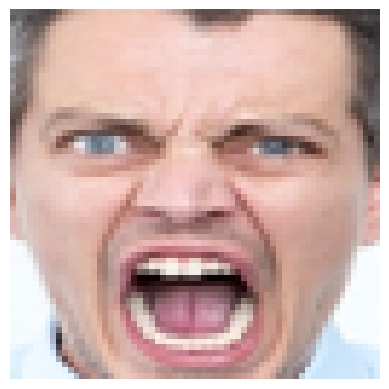

yes


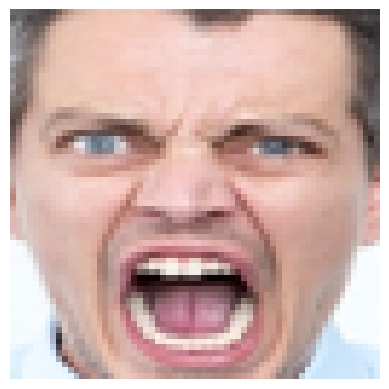

angry


In [60]:
import matplotlib.pyplot as plt

def show_image(image, grayscale=False):
    plt.imshow(image, cmap='gray' if grayscale else None)
    plt.axis('off')
    plt.show()

# Choose an image index from X_train1
image_index = 3

# Show the image
show_image(X_train1[image_index], grayscale=True)

# Check if the image is RGB
if len(X_train1.shape) == 4:
    print("yes")
    show_image(X_train1[image_index])

print(classifications_names[Y_train1[image_index]])



In [61]:
def preprocess_data(x, y, limit,classifications,image_shape):
    indices = []
    for i in range(len(classifications)):
      indices.append(np.where(y == i)[0][:limit])
    all_indices = np.hstack(indices)
    all_indices = np.random.permutation(all_indices)
    x, y = x[all_indices], y[all_indices]
    x = x.reshape(len(x), image_shape[0],image_shape[1],image_shape[2])
    x = x/255
    y = to_categorical(y)
    y = y.reshape(len(y), len(classifications), 1)
    return x, y

In [62]:
x_train, y_train = preprocess_data(X_train1, Y_train1, 1500, classifications, image_shape)
x_test, y_test = preprocess_data(X_test1, Y_test1, 1500, classifications, image_shape)

In [63]:
print("x_train shape:",x_train.shape)
print("y_train shape:",y_train.shape)
print("x_test shape:",x_test.shape)
print("y_test shape:",y_test.shape)

x_train shape: (3152, 3, 64, 64)
y_train shape: (3152, 4, 1)
x_test shape: (788, 3, 64, 64)
y_test shape: (788, 4, 1)


(3, 64, 64)


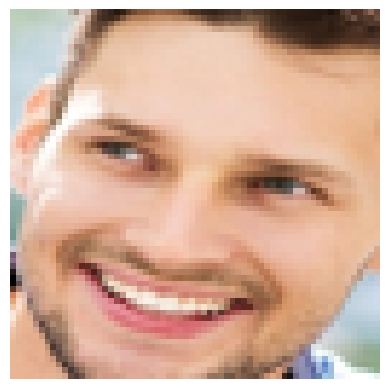

happy


In [64]:
image = x_train[image_index]
print(image.shape)
image = image.reshape(image_shape[2],image_shape[1],image_shape[0])
# Show the image
show_image(image, grayscale=True)

# Check if the image is RGB
if x_train.shape[0] == 3:
    show_image(x_train[image_index])

print(classifications_names[np.argmax(y_train[image_index])])

##**Train Model**##

In [ ]:
# print(np.prod(image_shape))
# neural network
x_train_flatten = x_train.reshape(x_train.shape[0], np.prod(image_shape), 1)
x_test_flatten = x_test.reshape(x_test.shape[0], np.prod(image_shape), 1)
print(x_train_flatten.shape)
print(x_test_flatten.shape)
network = [
    DenseLayer(np.prod((image_shape)), 128, 0.001,'Dense1'),
    Activation("relu"),
    DenseLayer(128, len(classifications), 0.001,'Dense2'),
    Activation("softmax")
]
net = Network(network)
print(net)

model = DLModel('model', net, "categorical_cross_entropy")
costs = model.train(x_train_flatten, y_train, 20)

(3152, 12288, 1)
(788, 12288, 1)
Network: 
1. Dense Layer:
	learning_rate (alpha): 0.001
	num inputs: 12288
	num units: 128
	Parameters shape:
		W shape: (128, 12288)
		b shape: (128, 1)

2. Activation function: relu

3. Dense Layer:
	learning_rate (alpha): 0.001
	num inputs: 128
	num units: 4
	Parameters shape:
		W shape: (4, 128)
		b shape: (4, 1)

4. Activation function: softmax


error after 1 updates (5%): 0.35580299294852746
error after 2 updates (10%): 0.2332704024443922
error after 3 updates (15%): 0.21545988218698592


In [ ]:
print_costs(costs,20)
net.save_parameters("/content/drive/MyDrive/Colab Notebooks")

In [ ]:
# prompt: create a function that takes a bunch of data and splits x_test and y_test to every image and feeds it to the net and messures the accuracy of the network, add a boolean parameter witch adds the option to deicide if the results for each image would be shown or not

def test_model(net,x_test,y_test,show_results=True):
  correct = 0
  for i in range(len(x_test)):
    x = x_test[i]
    y = y_test[i]
    y_hat = net.forward_propagation(x)
    predicted_class = np.argmax(y_hat)
    actual_class = np.argmax(y)
    if predicted_class == actual_class:
      correct += 1
    if show_results:
      print(f"Image {i+1}: Predicted class: {predicted_class}, Actual class: {actual_class}, Correct: {predicted_class == actual_class}")
  accuracy = correct / len(x_test)
  print(f"Accuracy: {accuracy*100:.2f}%")

test_model(net,x_test_flatten,y_test,False)

In [ ]:
# prompt: create a function called evaluate image that gets as input an image numpy array and outputs the prediction, add a string array parameter called classifications that by it would output the name of the classification

def evaluate_image(image, classifications):
  """
  Evaluates an image and outputs the prediction.

  Args:
    image (np.ndarray): The image to evaluate.
    classifications (list): A list of classification names.

  Returns:
    tuple: A tuple containing the predicted class index and the predicted class name.
  """

  # Make a prediction
  y_hat = net.forward_propagation(image)
  predicted_class_index = np.argmax(y_hat)

  # Get the predicted class name
  predicted_class_name = classifications[predicted_class_index]

  return predicted_class_index, predicted_class_name,y_hat

image_index = np.random.randint(0, len(x_test))
image = x_test[image_index]
image = image.reshape(image_shape[2],image_shape[1],image_shape[0])
# Show the image
show_image(image, grayscale=True)

# Check if the image is RGB
if image.shape[1] == 3:
    show_image(image)

image = image.reshape(np.prod(image_shape), 1)

predicted_class_index, predicted_class_name,prediction = evaluate_image(image, classifications_names)
print(f"Predicted class: {predicted_class_name}")
# print(f"Prediction: {prediction}")
print(f"Real class: {classifications_names[np.argmax(y_test[image_index])]}")